In [436]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime, timedelta

from dotenv import load_dotenv

from alpaca.data.requests import StockBarsRequest
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [437]:
# Load .env file

load_dotenv()

True

In [438]:
# Set Alpaca API key and secret

ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_API_SECRET")
client = StockHistoricalDataClient(ALPACA_API_KEY, ALPACA_SECRET_KEY)

# Create the Alpaca API object

timeframe = TimeFrame(1, TimeFrameUnit.Day)
symbol = 'SPY'
start = datetime.utcnow() - timedelta(days=1600)
end=datetime.utcnow() - timedelta(days=5)
request = StockBarsRequest(symbol_or_symbols=symbol, start=start, end=end, timeframe=timeframe)

In [439]:
source_df = client.get_stock_bars(request).df.tz_convert('America/New_York', level=1)

In [440]:
display(source_df.tail())

open    high      low   close  \
symbol timestamp                                                    
SPY    2024-02-12 00:00:00-05:00  501.17  503.50  500.240  500.98   
       2024-02-13 00:00:00-05:00  494.53  497.09  490.715  494.08   
       2024-02-14 00:00:00-05:00  496.79  499.07  494.400  498.57   
       2024-02-15 00:00:00-05:00  499.29  502.20  498.795  502.01   
       2024-02-16 00:00:00-05:00  501.70  502.87  498.750  499.51   

                                       volume  trade_count        vwap  
symbol timestamp                                                        
SPY    2024-02-12 00:00:00-05:00   56502283.0     437189.0  501.538780  
       2024-02-13 00:00:00-05:00  113099199.0     779480.0  494.284048  
       2024-02-14 00:00:00-05:00   68387827.0     536843.0  496.719466  
       2024-02-15 00:00:00-05:00   61682960.0     516093.0  500.763897  
       2024-02-16 00:00:00-05:00   75481032.0     531239.0  500.924740

In [441]:
bars_df = source_df.copy()
# pct_change is profit from last close
bars_df["pct_change"] = bars_df["close"].pct_change()
# signal for when we want to be in or out of a stock
#bars_df["signal"] = np.where(bars_df["pct_change"] > 0, 1.0, 0.0)
# reaction is the signal diff
#bars_df["reaction"] = bars_df["signal"].diff()
# action is if we could perfectly predict the next close
#bars_df["action"] = bars_df["reaction"].shift(-1)
# these values are the high, low, and open as a percentage of the current close
bars_df["high %"] = (bars_df["high"] - bars_df["close"])/bars_df["close"]
bars_df["low %"] = (bars_df["low"] - bars_df["close"])/bars_df["close"]
bars_df["open %"] = (bars_df["open"] - bars_df["close"])/bars_df["close"]

In [442]:
bars_df.info()
display(bars_df.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1099 entries, ('SPY', Timestamp('2019-10-07 00:00:00-0400', tz='America/New_York')) to ('SPY', Timestamp('2024-02-16 00:00:00-0500', tz='America/New_York'))
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         1099 non-null   float64
 1   high         1099 non-null   float64
 2   low          1099 non-null   float64
 3   close        1099 non-null   float64
 4   volume       1099 non-null   float64
 5   trade_count  1099 non-null   float64
 6   vwap         1099 non-null   float64
 7   pct_change   1098 non-null   float64
 8   high %       1099 non-null   float64
 9   low %        1099 non-null   float64
 10  open %       1099 non-null   float64
dtypes: float64(11)
memory usage: 138.8+ KB


open    high       low   close  \
symbol timestamp                                                     
SPY    2019-10-07 00:00:00-04:00  293.47  295.26  292.7700  293.10   
       2019-10-08 00:00:00-04:00  291.04  291.85  288.4900  288.66   
       2019-10-09 00:00:00-04:00  290.75  292.30  288.6559  291.12   
       2019-10-10 00:00:00-04:00  291.18  294.21  291.0000  293.29   
       2019-10-11 00:00:00-04:00  296.27  298.74  296.1448  296.25   

                                       volume  trade_count        vwap  \
symbol timestamp                                                         
SPY    2019-10-07 00:00:00-04:00   62088645.0     314251.0  293.832308   
       2019-10-08 00:00:00-04:00  103504306.0     495648.0  290.147031   
       2019-10-09 00:00:00-04:00   70229917.0     295519.0  291.056360   
       2019-10-10 00:00:00-04:00   57867131.0     335440.0  292.963831   
       2019-10-11 00:00:00-04:00  102672621.0     503205.0  297.165136   

                                  pct_change    high %     low %    open %  
symbol timestamp                                                            
SPY    2019-10-07 00:00:00-04:00         NaN  0.007369 -0.001126  0.001262  
       2019-10-08 00:00:00-04:00   -0.015148  0.011051 -0.000589  0.008245  
       2019-10-09 00:00:00-04:00    0.008522  0.004053 -0.008464 -0.001271  
       2019-10-10 00:00:00-04:00    0.007454  0.003137 -0.007808 -0.007194  
       2019-10-11 00:00:00-04:00    0.010092  0.008405 -0.000355  0.000068

In [443]:
# Cleanup DF for model

bars_df = bars_df.droplevel(level=0).dropna()
bars_df.head()

,open,high,low,close,volume,trade_count,vwap,pct_change,high %,low %,open %
timestamp,,,,,,,,,,,
2019-10-08 00:00:00-04:00,291.04,291.85,288.4900,288.66,103504306.0,495648.0,290.147031,-0.015148,0.011051,-0.000589,0.008245
2019-10-09 00:00:00-04:00,290.75,292.30,288.6559,291.12,70229917.0,295519.0,291.056360,0.008522,0.004053,-0.008464,-0.001271
2019-10-10 00:00:00-04:00,291.18,294.21,291.0000,293.29,57867131.0,335440.0,292.963831,0.007454,0.003137,-0.007808,-0.007194
2019-10-11 00:00:00-04:00,296.27,298.74,296.1448,296.25,102672621.0,503205.0,297.165136,0.010092,0.008405,-0.000355,0.000068
2019-10-14 00:00:00-04:00,295.93,296.67,295.5700,296.03,41283428.0,191853.0,296.132073,-0.000743,0.002162,-0.001554,-0.000338


In [444]:
# Normalize data set

scaler = StandardScaler()
bars_df_scaled = scaler.fit_transform(bars_df)


In [445]:
# Define constants

# input shape

input_shape = bars_df_scaled.shape[1]
latent_dim = 11
num_samples = bars_df_scaled.shape[0]
batch_size = 32

# Generate Random Walk noise

gaussian_noise = np.random.normal(0,1,size=(batch_size,input_shape))
random_walk_noise = np.cumsum(gaussian_noise, axis=0)


In [446]:
# Define generator

build_generator = Sequential([
    Dense(128,input_shape=(input_shape,), activation="relu"),
    Dense(256, activation="relu"),
    Dense(512, activation="relu"),
    Dense(input_shape, activation="sigmoid")
])

# Define descriminator

build_discriminator = Sequential([
    Dense(512, input_shape=(input_shape,), activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [447]:
# Compile generator
build_generator.compile(loss = "mse", optimizer="adam")

# Compile discriminator
build_discriminator.compile(loss="mse", optimizer="adam")

In [448]:
# Combine models

z = tf.keras.Input(shape=(latent_dim,))
img = build_generator(z)
validity = build_discriminator(img)

In [449]:
# Define combined models

combined = tf.keras.Model(z, validity)
combined.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

# Print summary of the combined model
combined.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 11)]              0         
                                                                 
 sequential_28 (Sequential)  (None, 11)                171787    
                                                                 
 sequential_29 (Sequential)  (None, 1)                 170497    
                                                                 
Total params: 342284 (1.31 MB)
Trainable params: 342284 (1.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [450]:
# Define training loop
epochs = 1000
batch_size = 32
num_samples = bars_df_scaled.shape[0]

for epoch in range(epochs):
    # Train discriminator
    # Sample real data
    idx = np.random.choice(num_samples, batch_size, replace=False)
    real_data = bars_df_scaled[idx]
    # Generate fake data
    noise = random_walk_noise
    fake_data = build_generator.predict(random_walk_noise)
    # Train discriminator
    d_loss_real = build_discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = build_discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train generator
    noise = np.random.normal(0, 1, (batch_size, input_shape))
    g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
    
    # Print progress
    print(f"Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

1/1 [==============================] - 0s 34ms/step


2024-02-22 21:17:06.288310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-22 21:17:06.407740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-22 21:17:06.715402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 0, Discriminator Loss: 0.2896665781736374, Generator Loss: [0.27671611309051514, 0.0]
1/1 [==============================] - 0s 12ms/step
Epoch 1, Discriminator Loss: 0.2755270153284073, Generator Loss: [0.2998466193675995, 0.0]
1/1 [==============================] - 0s 12ms/step
Epoch 2, Discriminator Loss: 0.23933595418930054, Generator Loss: [0.3625606298446655, 0.0]
1/1 [==============================] - 0s 12ms/step
Epoch 3, Discriminator Loss: 0.2234175130724907, Generator Loss: [0.38688230514526367, 0.0]
1/1 [==============================] - 0s 12ms/step
Epoch 4, Discriminator Loss: 0.2323327660560608, Generator Loss: [0.36080676317214966, 0.0]
1/1 [==============================] - 0s 13ms/step
Epoch 5, Discriminator Loss: 0.2204822674393654, Generator Loss: [0.36482325196266174, 0.0]
1/1 [==============================] - 0s 13ms/step
Epoch 6, Discriminator Loss: 0.2035106122493744, Generator Loss: [0.41634005308151245, 0.0]
1/1 [==============================] - 0s 12m

In [451]:
# Create alpaca object for testing

timeframe = TimeFrame(1, TimeFrameUnit.Day)
symbol = 'SPY'
start = datetime.utcnow() - timedelta(days=10)
end=datetime.utcnow() - timedelta(days=3)
request = StockBarsRequest(symbol_or_symbols=symbol, start=start, end=end, timeframe=timeframe)

In [452]:
# Create df for testing

test_df = client.get_stock_bars(request).df.tz_convert('America/New_York', level=1)

# data preprocessing for testing

# pct_change is profit from last close
test_df["pct_change"] = test_df["close"].pct_change()
# signal for when we want to be in or out of a stock
#bars_df["signal"] = np.where(bars_df["pct_change"] > 0, 1.0, 0.0)
# reaction is the signal diff
#bars_df["reaction"] = bars_df["signal"].diff()
# action is if we could perfectly predict the next close
#bars_df["action"] = bars_df["reaction"].shift(-1)
# these values are the high, low, and open as a percentage of the current close
test_df["high %"] = (test_df["high"] - test_df["close"])/test_df["close"]
test_df["low %"] = (test_df["low"] - test_df["close"])/test_df["close"]
test_df["open %"] = (test_df["open"] - test_df["close"])/test_df["close"]

# set timestamp as index, drop nan

test_df = test_df.droplevel(level=0).dropna()

test_df.info()
display(test_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3 entries, 2024-02-14 00:00:00-05:00 to 2024-02-16 00:00:00-05:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         3 non-null      float64
 1   high         3 non-null      float64
 2   low          3 non-null      float64
 3   close        3 non-null      float64
 4   volume       3 non-null      float64
 5   trade_count  3 non-null      float64
 6   vwap         3 non-null      float64
 7   pct_change   3 non-null      float64
 8   high %       3 non-null      float64
 9   low %        3 non-null      float64
 10  open %       3 non-null      float64
dtypes: float64(11)
memory usage: 288.0 bytes


,open,high,low,close,volume,trade_count,vwap,pct_change,high %,low %,open %
timestamp,,,,,,,,,,,
2024-02-14 00:00:00-05:00,496.79,499.07,494.400,498.57,68387827.0,536843.0,496.719466,0.009088,0.001003,-0.008364,-0.003570
2024-02-15 00:00:00-05:00,499.29,502.20,498.795,502.01,61682960.0,516093.0,500.763897,0.006900,0.000378,-0.006404,-0.005418
2024-02-16 00:00:00-05:00,501.70,502.87,498.750,499.51,75481032.0,531239.0,500.924740,-0.004980,0.006727,-0.001521,0.004384


In [453]:
# Normalize test data set

test_df_scaled = scaler.fit_transform(test_df)

print(test_df_scaled)

[[-1.23215904 -1.39479259 -1.41415739 -1.00570938 -0.02297675  1.0022861
  -1.41340788  0.87667542 -0.59500317 -1.01977988 -0.47862307]
 [ 0.01496549  0.49512118  0.71799415  1.36390724 -1.21309484 -1.3651841
   0.66536851  0.52269306 -0.81356926 -0.33865985 -0.91315971]
 [ 1.21719355  0.89967141  0.69616325 -0.35819786  1.23607159  0.362898
   0.74803938 -1.39936849  1.40857243  1.35843973  1.39178278]]


In [454]:
# evaluate discriminator on test data

from sklearn.metrics import classification_report, confusion_matrix

discriminator_predictions = build_discriminator.predict(test_df_scaled)

print(confusion_matrix(np.ones(len(test_df_scaled)),discriminator_predictions))
print(classification_report(np.ones(len(test_df_scaled)),discriminator_predictions))

1/1 [==============================] - 0s 34ms/step
[[0 0]
 [2 1]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.33      0.50         3

    accuracy                           0.33         3
   macro avg       0.50      0.17      0.25         3
weighted avg       1.00      0.33      0.50         3



2024-02-22 21:18:06.454444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/ebrown/anaconda3/envs/GAN_kernel/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ebrown/anaconda3/envs/GAN_kernel/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ebrown/anaconda3/envs/GAN_kernel/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set

1/1 [==============================] - 0s 12ms/step


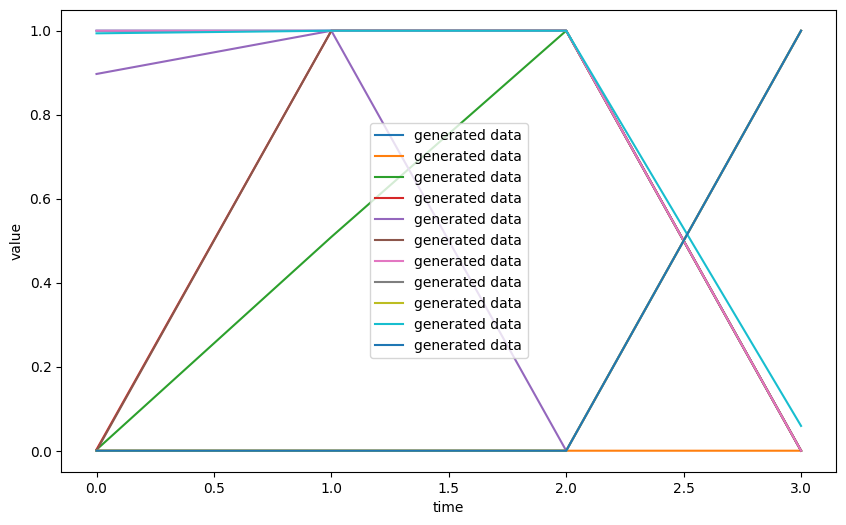

In [455]:
import matplotlib.pyplot as plt
generated_data = build_generator.predict(random_walk_noise)

plt.figure(figsize=(10,6))
plt.plot(generated_data[:4], label="generated data")
plt.xlabel("time")
plt.ylabel("value")
plt.legend()
plt.show()

In [456]:
print("original df shape", test_df_scaled.shape)
print("generated df shape", generated_data.shape)

print("Original dataframe summary statistics:")
print((test_df_scaled))

original df shape (3, 11)
generated df shape (32, 11)
Original dataframe summary statistics:
[[-1.23215904 -1.39479259 -1.41415739 -1.00570938 -0.02297675  1.0022861
  -1.41340788  0.87667542 -0.59500317 -1.01977988 -0.47862307]
 [ 0.01496549  0.49512118  0.71799415  1.36390724 -1.21309484 -1.3651841
   0.66536851  0.52269306 -0.81356926 -0.33865985 -0.91315971]
 [ 1.21719355  0.89967141  0.69616325 -0.35819786  1.23607159  0.362898
   0.74803938 -1.39936849  1.40857243  1.35843973  1.39178278]]


In [457]:
print("Generated dataframe summary statistics:")
print(pd.DataFrame(generated_data))

Generated dataframe summary statistics:
              0             1             2             3             4   \
0   1.000000e+00  9.542911e-05  2.384970e-03  2.787823e-03  8.970282e-01   
1   1.000000e+00  1.885809e-16  5.090092e-01  9.999965e-01  1.000000e+00   
2   1.000000e+00  2.990484e-05  1.000000e+00  1.000000e+00  2.563813e-12   
3   1.841903e-12  1.972008e-07  1.467661e-24  1.299798e-26  9.999996e-01   
4   1.000000e+00  9.997774e-01  8.007740e-01  8.311570e-02  1.504658e-08   
5   1.000000e+00  1.523944e-13  1.660767e-09  1.207429e-08  9.983532e-01   
6   1.000000e+00  9.958693e-01  1.000000e+00  1.000000e+00  7.970783e-30   
7   1.000000e+00  9.659131e-01  1.000000e+00  1.000000e+00  6.861977e-21   
8   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  2.206549e-26   
9   6.459171e-12  1.000000e+00  6.799999e-17  4.001357e-25  2.719022e-12   
10  0.000000e+00  1.000000e+00  3.295828e-30  0.000000e+00  4.279485e-11   
11  0.000000e+00  1.000000e+00  1.359469e-08  1.

In [458]:
generated_data_inverse = scaler.inverse_transform(generated_data)
generated_data_df = pd.DataFrame(generated_data_inverse)
generated_data_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,501.264618,501.380157,497.319916,500.034058,73570936.0,528058.4375,501.414948,0.003669,0.002703,-0.002571,-0.001535
1,501.264618,501.380005,498.364227,501.481720,74151056.0,536822.9375,501.414948,0.003669,0.002703,-0.002553,-0.001535
2,501.264618,501.380035,499.376312,501.481720,68517272.0,536822.9375,501.414948,0.003669,0.002703,-0.002553,-0.001535
3,499.260010,501.380005,497.315002,500.029999,74151056.0,528058.3125,499.469360,0.009850,0.005559,-0.005260,0.002718
4,501.264618,503.035797,498.965637,500.150665,68517272.0,528058.3125,501.374390,0.003869,0.002703,-0.002924,-0.001534


In [459]:
# Create alpaca object for testing

timeframe = TimeFrame(1, TimeFrameUnit.Day)
symbol = 'SPY'
start = datetime.utcnow() - timedelta(days=3)
end=datetime.utcnow() - timedelta(days=1)
request = StockBarsRequest(symbol_or_symbols=symbol, start=start, end=end, timeframe=timeframe)

current_df = client.get_stock_bars(request).df.tz_convert('America/New_York', level=1)
current_df.head()

open    high     low   close      volume  \
symbol timestamp                                                               
SPY    2024-02-20 00:00:00-05:00  497.72  498.41  494.45  496.76  71736740.0   
       2024-02-21 00:00:00-05:00  495.42  497.37  493.56  497.21  59381397.0   

                                  trade_count        vwap  
symbol timestamp                                           
SPY    2024-02-20 00:00:00-05:00     595486.0  496.441094  
       2024-02-21 00:00:00-05:00     497559.0  495.813866

In [460]:
# # Define constants

# latent_dim = 100
# input_shape = bars_df.shape[1]
# output_shape = bars_df.shape[1]
# num_samples = 1000
# gaussian_noise = np.random.normal(0,1,size=(num_samples, latent_dim))
# random_walk_noise = np.cumsum(gaussian_noise,axis=0)

In [461]:
# # define model building functions

# def build_generator(num_layers,layer_size,activation,output_activation):
#     model = models.Sequential()
#     model.add(layers.Dense(layer_size, activation = activation, input_dim=num_layers))

#     for _ in range(num_layers-1):
#         model.add(layers.Dense(layer_size, activation = activation))

#     model.add(layers.Dense(output_shape,activation = output_activation))

#     pass

# # def build_discriminator(layers,layer_size,activation):

# def build_discriminator(num_layers,layer_size,activation):
#     model = models.Sequential()
#     model.add(layers.Dense(layer_size, activation = activation, input_dim = input_shape))

#     for _ in range(num_layers - 1):
#         model.add(layers.Dense(layer_size, activation = activation))

#     model.add(layers.Dense(1))

#     pass

In [462]:
# Normalize data set

scaler = StandardScaler()
bars_df_scaled = scaler.fit_transform(bars_df)


In [463]:
from sklearn.base import BaseEstimator

class GeneratorWrapper(BaseEstimator):
    def __init__(self, num_layers, layer_size, activation, output_activation):
        self.num_layers = num_layers
        self.layer_size = layer_size
        self.activation = activation
        self.output_activation = output_activation
        self.model = None

    def fit(self, X, y=None):
        # Build generator model
        self.model = build_generator(self.num_layers, self.layer_size, self.activation, self.output_activation)
        # Compile the model
        self.model.compile(loss='binary_crossentropy', optimizer='adam')
        # Fit the model
        self.model.fit(X, X, epochs=3, batch_size=64, verbose=0)  # Assuming autoencoder-like training
        return self

class DiscriminatorWrapper(BaseEstimator):
    def __init__(self, num_layers=2, layer_size=128, activation='relu'):
        self.num_layers = num_layers
        self.layer_size = layer_size
        self.activation = activation
        self.model = None

    def fit(self, X, y=None):
        # Build discriminator model
        self.model = build_discriminator(self.num_layers, self.layer_size, self.activation)
        # Compile the model
        self.model.compile(loss='binary_crossentropy', optimizer='adam')
        # Fit the model
        self.model.fit(X, y, epochs=3, batch_size=64, verbose=0)  # Assuming binary classification
        return self

In [464]:
# # Perform girdsearch for generator

# generator_search = GridSearchCV(estimator=build_generator, param_grid=generator_grid, cv = 3)
# generator_search.fit(random_walk_noise, bars_df_scaled)
# best_generator_params = generator_search.best_params_

# # get the best output layer activation from gridsearch

# output_activation = best_generator_params.pop("output_activation")

# # Build the generator with the best parameters
# generator = build_generator(latent_dim, output_shape, output_activation, **best_generator_params)

# # Perform grid search for discriminator
# discriminator_search = GridSearchCV(estimator=build_discriminator, param_grid=discriminator_grid, cv=3)
# discriminator_search.fit(random_walk_noise,bars_df_scaled)
# best_discriminator_params = discriminator_search.best_params_

# # Build the discriminator with the best parameters
# discriminator = build_discriminator(**best_discriminator_params)



In [465]:
# Create GridSearchCV instance for the generator
generator_search = GridSearchCV(estimator=GeneratorWrapper(), param_grid=generator_grid, cv=3)
generator_search.fit(random_walk_noise, bars_df_scaled)
best_generator_params = generator_search.best_params_

# Create GridSearchCV instance for the discriminator
discriminator_search = GridSearchCV(estimator=DiscriminatorWrapper(), param_grid=discriminator_grid, cv=3)
discriminator_search.fit(bars_df_scaled)
best_discriminator_params = discriminator_search.best_params_

print("Best parameters for the generator:", best_generator_params)
print("Best parameters for the discriminator:", best_discriminator_params)

TypeError: __init__() missing 4 required positional arguments: 'num_layers', 'layer_size', 'activation', and 'output_activation'